In [1]:
import numpy as np
import pandas as pd 
import warnings
import pickle
import wandb
import time
import tqdm

In [2]:
api = wandb.Api(timeout=60)
entity, project = 'the-real-dl', 'bio-transformers'
runs = api.runs(entity + '/' + project)
dataset = 'mnist'

In [3]:
your_sweep_ids = [
    '4do451d5', # mnist-bp-adagrad
    '5yeeq2a4', # mnist-bp-adam
    'up3qoeyj', # mnist-bp-rmsprop
    'rmpdpbsc', # mnist-bp-momentum
    'jvmkpt8s', # mnist-pc-adagrad-adam
    'zhqld4ne', # mnist-pc-adam-adam
    '11pqrpdd', # mnist-pc-rmsprop-adam
    'exahtn7j', # mnist-pc-momentum-adam
    'ev5y7qxc', # mnist-pc-adagrad-momentum
    'sc89svlq', # mnist-pc-adam-momentum
    'gb9m1a0b', # mnist-pc-rmsprop-momentum
    '80zbdwm3', # mnist-pc-momentum-momentum
]

In [33]:
def metrics(run_id):
    r = api.run(f'{entity}/{project}/{run_id}')
    e = r.config['epochs']
    df = r.history(samples=r.config['epochs'] * 3)
    df = df[[col for col in df.columns if col in ['epoch', 'train_loss', 'test_loss', 'train_energy']]]
    df['c_loss'] = r.config['loss']
    df['c_dataset'] = r.config['dataset']
    df['c_training'] = r.config['training']
    return df

In [4]:
def extract(wandb_runs, maxrun=None):
    
    dfs = []
    count = 0

    for i, run in enumerate(runs):
        # time.sleep(2) # to avoid 429 Client Error
        print(f'Fetching run #{i}', end='\r')
        if maxrun is not None and count == maxrun: break

        summary = run.summary
        if not 'epoch' in summary.keys(): continue
        if run.state == 'running': continue
        if run.state == 'crashed': continue
        if run.state == 'failed': continue

        run_id = run.id
        sweep_id = run.sweep.id

        if sweep_id not in your_sweep_ids: continue

        config = run.config
        run_df = run.history()

        config.update({'sweep-id': sweep_id, 'run-id': run_id})
        summary.update({'sweep-id': sweep_id, 'run-id': run_id})

        l_epochs = []
        l_train_loss = []
        l_test_loss = []
        l_train_energy = []

        for e in range(summary['epoch']):
            x = run_df[run_df.epoch == e]
            if len(x.index) == 0: continue

            train_losses = x.train_loss.unique()
            test_losses = x.test_loss.unique()

            train_loss_no_nan = train_losses[~np.isnan(train_losses)]
            test_loss_no_nan = test_losses[~np.isnan(test_losses)]

            train_loss = train_loss_no_nan[0] if len(train_loss_no_nan) > 0 else np.nan
            test_loss = test_loss_no_nan[0] if len(test_loss_no_nan) > 0 else np.nan

            l_epochs.append(e)
            l_train_loss.append(train_loss)
            l_test_loss.append(test_loss)

            if config['training'] == 'pc':
                train_energies = x.train_energy.unique()
                train_energy_no_nan = train_energies[~np.isnan(train_energies)]
                train_energy = train_energy_no_nan[0] if len(train_energy_no_nan) > 0 else np.nan
                l_train_energy.append(train_energy)

            if config['training'] == 'bp':
                run_ids = np.full(len(l_epochs), run_id)
                sweep_ids = np.full(len(l_epochs), sweep_id)
                data = list(zip(sweep_ids, run_ids, l_epochs, l_train_loss, l_test_loss))
                columns = ['sweep_id', 'run_id', 'epoch', 'train_loss', 'test_loss']
            else:
                run_ids = np.full(len(l_epochs), run_id)
                sweep_ids = np.full(len(l_epochs), sweep_id)
                data = list(zip(sweep_ids, run_ids, l_epochs, l_train_loss, l_test_loss, l_train_energy))
                columns = ['sweep_id', 'run_id', 'epoch', 'train_loss', 'test_loss', 'train_energy']

        df = pd.DataFrame(data, columns=columns)

        # adding configs to df
        for k in list(config.keys())[:-2]:
            df['c_' + str(k)] = config[k]

        # adding summary to df
        for k in summary.keys():
            if k in ['_runtime', 'train_loss', 'test_loss', 'train_energy']:
                df['f_' + str(k)] = summary[k]

        dfs.append(df)
        count += 1


    print(f'Fetched {count} runs in {runs.entity}/{runs.project} (max runs: {"all" if maxrun is None else maxrun})')
    return pd.concat(dfs, axis=0).reset_index(drop=True)

In [5]:
def sort_runs_by_test_loss(df, top=None):
    x = df.drop(columns=['epoch', 'train_loss', 'test_loss', 'train_energy'])
    x = x.drop(columns=['c_loss', 'c_seed', 'c_model', 'c_wandb', 'c_device'])
    x = x.drop(columns=['c_epochs', 'c_dataset', 'c_dropout', 'c_batch-size'])

    if x.c_training.unique()[0] == 'bp':
        x = x.drop(columns=[c for c in list(x.columns) if c.startswith('c_pc')])
        x = x.drop(columns=['c_clr', 'c_init', 'c_iterations', 'c_x_optimizer', 'f_train_energy'])

    x = x.drop_duplicates().reset_index(drop=True)
    x = x.sort_values('f_test_loss', ascending=True).reset_index(drop=True)

    return x if top is None else x[:top]

In [6]:
def top_parameters(df):
    df_params = pd.DataFrame(columns=['parameter', 'abs_best', 'mean_best', 'median_best'])
    params = [c for c in df.columns if c.startswith('c')]

    for param in params:
        abs_best = df.loc[0, param]
        mean_best = df.groupby(param).agg({'f_test_loss': np.mean}).reset_index().iloc[0, 0]
        median_best = df.groupby(param).agg({'f_test_loss': np.median}).reset_index().iloc[0, 0]
        df_params = df_params.append({'parameter': param, 'abs_best': abs_best, 'mean_best': mean_best, 'median_best': median_best}, ignore_index=True)

    return df_params

In [7]:
def correlation_stats(df):
    corr_train_loss = df.corr()['train_loss']
    corr_test_loss = df.corr()['test_loss']
    corr_train_energy = df.corr()['train_energy']
    corr_train_loss = corr_train_loss[corr_train_loss.index.str.startswith(('c_'))].sort_values(ascending=False)
    corr_test_loss = corr_test_loss[corr_test_loss.index.str.startswith(('c_'))].sort_values(ascending=False)
    corr_train_energy = corr_train_energy[corr_train_energy.index.str.startswith(('c_'))].sort_values(ascending=False)
    return corr_train_loss, corr_test_loss, corr_train_energy

In [40]:
def plot_metrics(run_id):
    df = metrics(run_id)
    xlabel = 'epochs'
    ylabel = df.c_loss[0]
    title = f'{df.c_training[0]} {df.c_dataset[0]} run {run_id}'

    train_l = df[['epoch', 'train_loss']].dropna().train_loss
    train_loss =df[['epoch', 'train_loss']].dropna()[(train_l > np.quantile(train_l, 0.01)) & (train_l < np.quantile(train_l, 0.99))]

     # we can add fancy std-err visualizations and co.
    ax = train_loss.plot(x='epoch', legend='train loss', xlabel=xlabel, ylabel=ylabel, title=title, figsize=(10, 4), logy=True)
    df[['epoch', 'test_loss']].dropna().plot(x='epoch', legend='test loss', xlabel=xlabel, ylabel=ylabel, title=title, figsize=(10, 4), ax=ax, logy=True)
    if 'train_energy' in df.columns:
        df[['epoch', 'train_energy']].dropna().plot(x='epoch', legend='train energy', xlabel=xlabel, ylabel=ylabel, title=title, figsize=(10, 4), logy=True, color='green')

In [23]:
def plot_run(df, run_id):
    xlabel = 'epochs'
    ylabel = df[df.run_id == run_id].c_loss.unique()[0]
    title = f'{df[df.run_id == run_id].c_dataset.unique()[0]} run {run_id}'
    # we can add fancy std-err visualizations and co.
    df[df.run_id == run_id].train_loss.plot(x='epoch', legend='train loss', xlabel=xlabel, ylabel=ylabel, title=title, figsize=(10, 4))
    df[df.run_id == run_id].test_loss.plot(x='epoch', legend='test loss', xlabel=xlabel, ylabel=ylabel, title=title, figsize=(10, 4))
    if 'train_energy' in df[df.run_id == run_id].columns:
        df[df.run_id == run_id].train_energy.plot(x='epoch', legend='train energy', xlabel=xlabel, ylabel=ylabel, title=title, figsize=(10, 4))

In [9]:
# with warnings.catch_warnings():
df = extract(runs, maxrun=None)
# df.to_csv(f'runs/{dataset}-wandb-runs.csv')

df_bp = df[(df.c_training == 'bp')]
df_pc = df[(df.c_training == 'pc')]

Fetched 1377 runs in the-real-dl/bio-transformers (max runs: all)


In [10]:
top_bp = sort_runs_by_test_loss(df_bp, top=100)
top_pc = sort_runs_by_test_loss(df_pc, top=100)

In [11]:
top_bp[:5]

,sweep_id,run_id,c_lr,c_training,c_optimizer,c_batch_size,c_weight_decay,c_learning_rate,f__runtime,f_train_loss,f_test_loss,c_gamma,c_momentum
0,rmpdpbsc,at1z2u12,0.0050,bp,momentum,1,0.0005,0.0050,27662.682187,0.034829,0.058868,0.10,0.6
1,rmpdpbsc,ywl4776b,0.0100,bp,momentum,1,0.0005,0.0100,28750.492724,0.033007,0.059441,0.10,0.6
2,rmpdpbsc,8hdm8d7i,0.0100,bp,momentum,1,0.0005,0.0100,28194.502354,0.033007,0.059441,0.10,0.6
3,up3qoeyj,z3f55fk2,0.0005,bp,rmsprop,64,0.0005,0.0005,2714.762813,0.026027,0.059851,0.01,0.3
4,up3qoeyj,woad8ij5,0.0005,bp,rmsprop,64,0.0005,0.0005,2825.062196,0.026027,0.059851,0.50,0.3


In [12]:
top_pc[:5]

,sweep_id,run_id,c_lr,c_training,c_optimizer,c_batch_size,c_weight_decay,c_learning_rate,f__runtime,f_train_loss,...,c_pc_init,c_pc_iters,c_iterations,c_x_optimizer,c_pc_optimizer,c_pc_weight_dacay,c_pc_weight_decay,f_train_energy,c_pc_gamma,c_pc_momentum
0,sc89svlq,3hre1ayx,0.0005,pc,adam,32,0.0001,0.0005,78212.335829,1.478024,...,forward,50.0,50.0,momentum,momentum,0.0,0.0,0.000107,0.10,0.5
1,sc89svlq,2qfen0oh,0.0005,pc,adam,128,0.0001,0.0005,30582.882200,1.475831,...,forward,50.0,50.0,momentum,momentum,0.0,0.0,0.000088,0.50,0.5
2,sc89svlq,l9kyo6t0,0.0001,pc,adam,128,0.0001,0.0001,40783.872676,1.480674,...,forward,50.0,50.0,momentum,momentum,0.0,0.0,0.000128,0.10,0.5
3,80zbdwm3,r5j9zgmm,0.0100,pc,momentum,1,0.0001,0.0100,77763.047669,1.479324,...,forward,50.0,50.0,momentum,momentum,0.0,0.0,0.000390,0.01,0.0
4,11pqrpdd,msdsprxl,0.0050,pc,rmsprop,32,0.0001,0.0050,50179.533957,1.509422,...,forward,50.0,50.0,adam,adam,0.0,0.0,0.007428,NaN,NaN


In [13]:
top_parameters(top_bp)

,parameter,abs_best,mean_best,median_best
0,c_lr,0.005,0.0001,0.0001
1,c_training,bp,bp,bp
2,c_optimizer,momentum,adam,adam
3,c_batch_size,1,1,1
4,c_weight_decay,0.0005,0.0005,0.0005
5,c_learning_rate,0.005,0.0001,0.0001
6,c_gamma,0.1,0.001,0.001
7,c_momentum,0.6,0,0


In [14]:
top_parameters(top_pc)

,parameter,abs_best,mean_best,median_best
0,c_lr,0.0005,0.0001,0.0001
1,c_training,pc,pc,pc
2,c_optimizer,adam,adagrad,adagrad
3,c_batch_size,32,1,1
4,c_weight_decay,0.0001,0,0
5,c_learning_rate,0.0005,0.0001,0.0001
6,c_gamma,NaN,0,0
7,c_momentum,NaN,0,0
8,c_clr,0.001,0.0001,0.0001
9,c_init,forward,forward,forward


In [15]:
_, bp_corr_test_loss, _ = correlation_stats(df_bp)
_, pc_corr_test_loss, _ = correlation_stats(df_pc)

In [16]:
bp_corr_test_loss

c_momentum           0.075097
c_gamma             -0.010270
c_learning_rate     -0.019408
c_lr                -0.019408
c_batch_size        -0.059452
c_batch-size        -0.059452
c_weight_decay      -0.148656
c_seed                    NaN
c_epochs                  NaN
c_dropout                 NaN
c_clr                     NaN
c_pc_clr                  NaN
c_pc_iters                NaN
c_iterations              NaN
c_pc_weight_dacay         NaN
c_pc_weight_decay         NaN
c_pc_gamma                NaN
c_pc_momentum             NaN
Name: test_loss, dtype: float64

In [17]:
pc_corr_test_loss

c_pc_gamma           0.048295
c_learning_rate      0.038402
c_lr                 0.038402
c_gamma              0.014412
c_momentum           0.010675
c_pc_momentum        0.009230
c_pc_weight_decay    0.000561
c_pc_weight_dacay    0.000561
c_batch_size        -0.012323
c_batch-size        -0.012323
c_epochs            -0.021177
c_pc_clr            -0.024626
c_clr               -0.024626
c_weight_decay      -0.027650
c_seed                    NaN
c_dropout                 NaN
c_pc_iters                NaN
c_iterations              NaN
Name: test_loss, dtype: float64

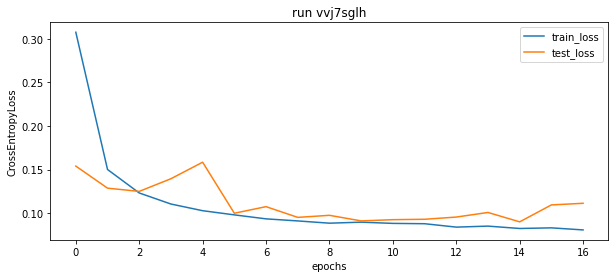

In [18]:
plot_run(df, 'vvj7sglh')

### energy review

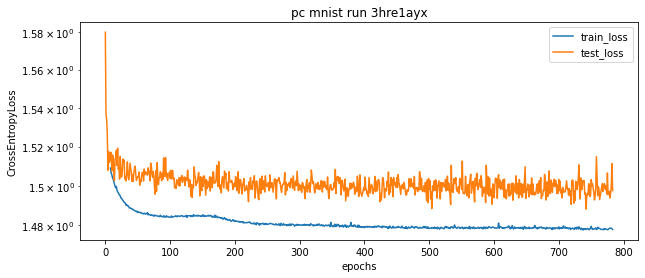

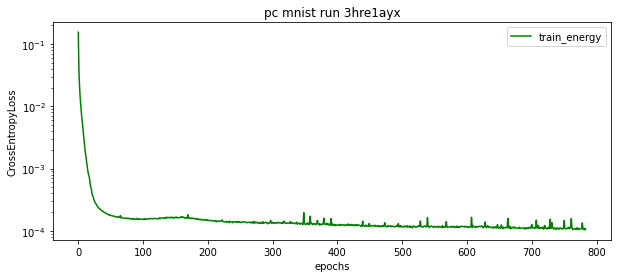

In [41]:
plot_metrics('3hre1ayx')